In [15]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from colorama import Fore
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


In [13]:
gpu = torch.device('cpu')

In [7]:
# ============================================= PREPARING DATASET ======================================================
epochs = 10
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
digits_per_sequence = 5
number_of_sequences = 10000
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
dataset_sequences = []
dataset_labels = []

for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28)))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)


100%|██████████| 561753746/561753746 [03:35<00:00, 2608704.90it/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [10]:
# ================================================= MODEL ==============================================================
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


model = CRNN().to(gpu)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train)
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  7553 / 8000 = 0.944125


  0%|          | 0/2000 [00:00<?, ?it/s]

TESTING. Correct:  1738 / 2000 = 0.869


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  7744 / 8000 = 0.968


  0%|          | 0/2000 [00:00<?, ?it/s]

TESTING. Correct:  1784 / 2000 = 0.892


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  7763 / 8000 = 0.970375


  0%|          | 0/2000 [00:00<?, ?it/s]

TESTING. Correct:  1780 / 2000 = 0.89


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  7807 / 8000 = 0.975875


  0%|          | 0/2000 [00:00<?, ?it/s]

TESTING. Correct:  1758 / 2000 = 0.879


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  7856 / 8000 = 0.982


  0%|          | 0/2000 [00:00<?, ?it/s]

TESTING. Correct:  1784 / 2000 = 0.892


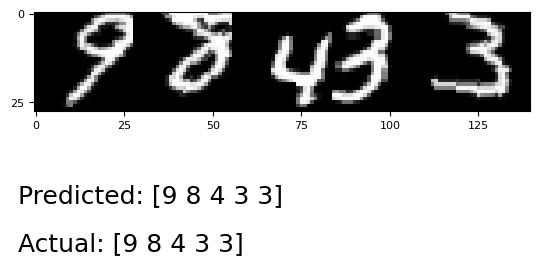

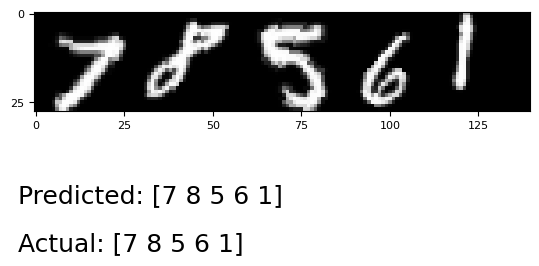

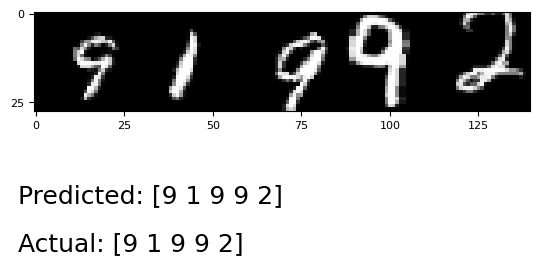

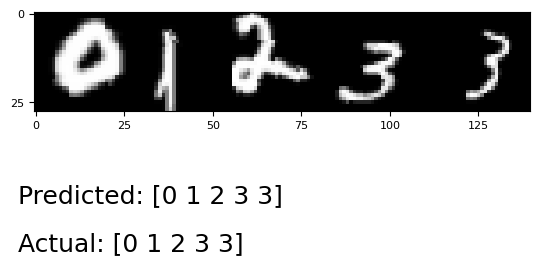

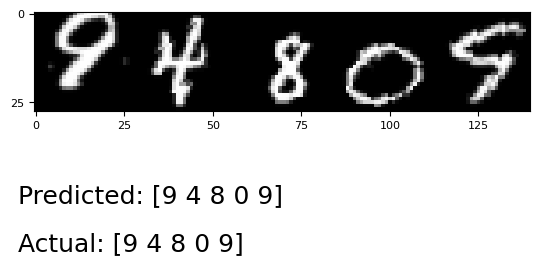

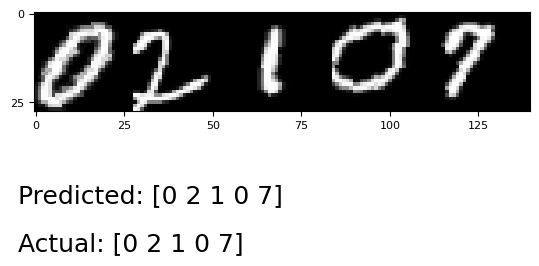

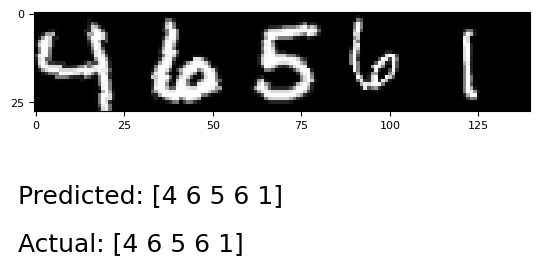

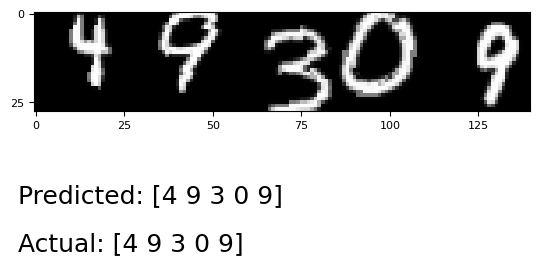

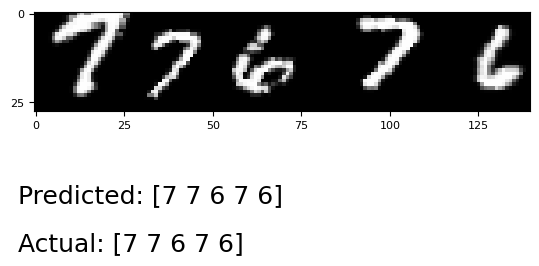

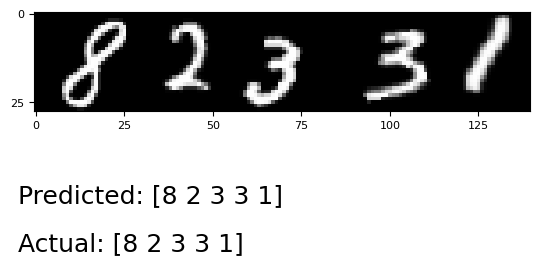

In [18]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()